In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk.sentiment.vader as vader
import pickle


In [3]:
DATASET_COLUMNS = ['target', 'ids', 'date', 'query', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
feedback_data = pd.read_csv('NEE.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
feedback_data.drop(feedback_data.columns[[0, 1, 2, 3, 4]], axis=1, inplace=True)

# Getting Null Values Count

np.sum(feedback_data.isnull().any(axis=1))

# Getting Dataset info

feedback_data.info()

# trying out different sizes of our data for testing
feedback_data = feedback_data.head(1000)

# printing the data frame but only the tail
feedback_data.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
dtypes: object(1)
memory usage: 12.2+ MB


,text
995,@dkoenigs thanks man. I'm so very grateful. ...
996,@t_wolfe i miss u too. i'm totally comin back...
997,@sniffinglue ohhh. I love it. ps I'm sad we di...
998,And somehow I still end up in this place
999,"@kisluvkis oh that is very sad, poor boy."


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HRIS2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HRIS2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HRIS2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


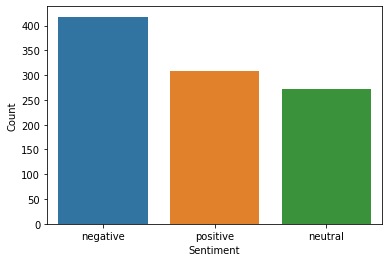

Total tweets: 1000
Positive tweets: 309
Negative tweets: 418
Neutral tweets: 273


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

feedback_data['text'] = feedback_data['text'].apply(preprocess_text)

sentiment_analyzer = vader.SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sentiment_analyzer.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

feedback_data['sentiment'] = feedback_data['text'].apply(analyze_sentiment)

# Count the sentiment labels
sentiment_counts = feedback_data['sentiment'].value_counts()

# Create bar plot of the sentiment counts
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Calculate total counts
positive = feedback_data ['sentiment'].value_counts()['positive']
negative = feedback_data ['sentiment'].value_counts()['negative']
neutral = feedback_data ['sentiment'].value_counts()['neutral']
total_count = positive + negative + neutral

# Print total counts
print(f'Total tweets: {total_count}')
print(f'Positive tweets: {positive}')
print(f'Negative tweets: {negative}')
print(f'Neutral tweets: {neutral}')

              precision    recall  f1-score   support

    negative       0.64      0.83      0.72        98
     neutral       0.52      0.50      0.51        46
    positive       0.76      0.39      0.52        56

    accuracy                           0.63       200
   macro avg       0.64      0.57      0.58       200
weighted avg       0.65      0.63      0.62       200



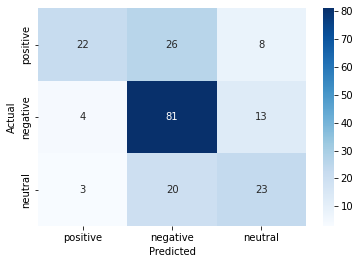

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(feedback_data['text'])
y = feedback_data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_classifier = MultinomialNB()
tree_classifier = DecisionTreeClassifier(random_state=42)

voting_classifier = VotingClassifier(estimators=[('nb', nb_classifier), ('tree', tree_classifier)], voting='hard')
voting_classifier.fit(X_train, y_train)

y_pred = voting_classifier.predict(X_test)

# Save the vectorizer to a pickle file
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save the voting classifier to a pickle file
with open('voting_classifier.pkl', 'wb') as f:
    pickle.dump(voting_classifier, f)
    
    
# Print classification report
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative', 'neutral'])

# Create confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [94]:
import re
import pandas as pd
from nltk.corpus import stopwords
import pickle
import tweepy as tw
import nltk
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))

negative_to_positive = {'not': 'great', 'bad': 'good', 'terrible': 'wonderful', 'enough': 'not enough'}
consumer_api_key = '3nVuSoBZnx6U4vzUxf5w'
consumer_api_secret = 'Bcs59EFbbsdF6Sl9Ng71smgStWEGwXXKSjYvPVt7qys'
auth = tw.OAuthHandler(consumer_api_key, consumer_api_secret)
api = tw.API(auth, wait_on_rate_limit=True)

#search_words = "new era university"
search_words = input('Search Twitter: ')
date_since = "2019-03-6"
date_until = "2023-12-6"

tweets = tw.Cursor(api.search_tweets,
                   q=search_words,
                   since=date_since,
                   until=date_until
                   ).items(1000)

tweets_copy = []
for tweet in tqdm(tweets):
    tweets_copy.append(tweet)
print(f"New tweets retrieved: {len(tweets_copy)}")

data = pd.DataFrame()
for tweet in tqdm(tweets_copy):
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
    except:
        pass
    data = data.append(pd.DataFrame({'user_name': tweet.user.name,
                                          'date': tweet.created_at,
                                          'text': tweet.text,
                                          }, index=[0]))

# Load the CSV file into a DataFrame and merge it with the existing datadf DataFrame
new_df = pd.read_csv('New_Era_University13.csv')
data = pd.concat([data, new_df], ignore_index=True)

    
data.tail()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HRIS2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HRIS2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HRIS2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Search Twitter: "new era university"


0it [00:00, ?it/s]Unexpected parameter: since
1it [00:00,  1.65it/s]Unexpected parameter: since
16it [00:01, 17.19it/s]Unexpected parameter: since
20it [00:01, 12.86it/s]


New tweets retrieved: 20


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\HRIS2\AppData\Local\Temp\ipykernel_16528\1062871109.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame({'user_name': tweet.user.name,
C:\Users\HRIS2\AppData\Local\Temp\ipykernel_16528\1062871109.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame({'user_name': tweet.user.name,
C:\Users\HRIS2\AppData\Local\Temp\ipykernel_16528\1062871109.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame({'user_name': tweet.user.name,
C:\Users\HRIS2\AppData\Local\Temp\ipykernel_16528\1062871109.py:45: FutureWarning: 

,user_name,date,text
139,NaN,2022-07-12 17:18:11+00:00,Sometimes the cashier is unresponsive but it's...
140,NaN,2022-07-12 17:17:59+00:00,It's okay\n#NewEraUniversityOnlineService #Reg...
141,NaN,2022-07-12 17:17:41+00:00,I can say that it doesn't have consistency. So...
142,NaN,2022-07-12 17:14:45+00:00,"Fair enough however, sometimes it will take yo..."
143,NaN,2022-07-12 16:53:46+00:00,"Fair enough however, sometimes it will take yo..."


In [2]:
import re
import pandas as pd
from nltk.corpus import stopwords
import pickle
import tweepy as tw
import nltk
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))

negative_to_positive = {'not': 'great', 'bad': 'good', 'terrible': 'wonderful', 'enough': 'not enough'}
consumer_api_key = '3nVuSoBZnx6U4vzUxf5w'
consumer_api_secret = 'Bcs59EFbbsdF6Sl9Ng71smgStWEGwXXKSjYvPVt7qys'
auth = tw.OAuthHandler(consumer_api_key, consumer_api_secret)
api = tw.API(auth, wait_on_rate_limit=True)

#search_words = "\"new era university\""
search_words = input('Search Twitter: ')
date_since = "2019-03-6"
date_until = "2023-12-6"

tweets = tw.Cursor(api.search_tweets,
                   q=search_words,
                   since=date_since,
                   until=date_until
                   ).items(1000)

tweets_copy = []
for tweet in tqdm(tweets):
    tweets_copy.append(tweet)
print(f"New tweets retrieved: {len(tweets_copy)}")

data = pd.DataFrame()
for tweet in tqdm(tweets_copy):
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
    except:
        pass
    data = data.append(pd.DataFrame({'user_name': tweet.user.name,
                                          'date': tweet.created_at,
                                          'text': tweet.text,
                                          }, index=[0]))

# Load the CSV file into a DataFrame and merge it with the existing datadf DataFrame
new_df = pd.read_csv('New_Era_University13.csv')
data = pd.concat([data, new_df], ignore_index=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HRIS2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HRIS2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HRIS2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Search Twitter: "new era university"


0it [00:00, ?it/s]Unexpected parameter: since
1it [00:00,  1.57it/s]Unexpected parameter: since
1it [00:01,  1.22s/it]


New tweets retrieved: 1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\HRIS2\AppData\Local\Temp\ipykernel_12420\797485736.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame({'user_name': tweet.user.name,
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


In [4]:
negative_to_positive = {'not': 'great', 'bad': 'good', 'terrible': 'wonderful', 'enough': 'not enough'}

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[#@]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the preprocess_text function to each row of the data DataFrame
data['text'] = data['text'].apply(preprocess_text)

# Load the vectorizer and the classifier
vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
voting_classifier = pickle.load(open('voting_classifier.pkl', 'rb'))

# Transform the data using the vectorizer
data_transformed = vectorizer.transform(data['text'])

# Make predictions using the classifier
predictions = voting_classifier.predict(data_transformed)

# Add the predictions as a new column to the data DataFrame
data['sentiment'] = predictions

# Define the custom order of the sentiment categories
order = {'negative': 0, 'neutral': 1, 'positive': 2}

# Sort the DataFrame by the 'sentiment' column using the custom order
data_sorted = data.sort_values(by='sentiment', key=lambda x: x.map(order))

LearningPlatform_keywords = ['#LearningPlatform','LearningPlatform','learningplatform','learningPlatform', 'NEUVLE', 'exam', 'quiz', 'seatwork','homework']
Cashier_keywords = ['cashier', 'cash']
Registrar_keywords = ['registrar', 'account','email']

data_sorted['category'] = 'general'
for index, row in data_sorted.iterrows():
    tweet = str(row['text']).lower()
    if any(keyword in tweet for keyword in LearningPlatform_keywords):
        data_sorted.at[index, 'category'] = 'LearningPlatform'
    elif any(keyword in tweet for keyword in Cashier_keywords):
        data_sorted.at[index, 'category'] = 'cashier'
    elif any(keyword in tweet for keyword in Registrar_keywords):
        data_sorted.at[index, 'category'] = 'registrar'

def modify_negative_text(text):
    words = text.split()
    for i, word in enumerate(words):
        if word in negative_to_positive.keys():
            words[i] = negative_to_positive[word]
    modified_text = ' '.join(words)
    return modified_text

for index, row in data_sorted.iterrows():
    sentiment = row['sentiment']
    text = row['text']
    category = row['category']
    if sentiment == 'negative':
        modified_text = modify_negative_text(text)
        if category == 'LearningPlatform':
            data_sorted.at[index, 'recommendation'] = f"Improvements can be made in the Learning Platform. {modified_text}"
        elif category == 'cashier':
            data_sorted.at[index, 'recommendation'] = f"Improvements can be made in the cashier service. {modified_text}"
        elif category == 'registrar':
            data_sorted.at[index, 'recommendation'] = f"Improvements can be made in the registrar service. {modified_text}"
        else:
            data_sorted.at[index, 'recommendation'] = modified_text
    elif sentiment == 'positive':
        if category == 'LearningPlatform':
            data_sorted.at[index, 'recommendation'] = "Great job on the Learning Platform!"
        elif category == 'cashier':
            data_sorted.at[index, 'recommendation'] = "Great job with the cashier service!"
        elif category == 'registrar':
            data_sorted.at[index, 'recommendation'] = "Great job with the registrar service!"
        else:
            data_sorted.at[index, 'recommendation'] = 'Keep up the good work!'
    else:
        data_sorted.at[index, 'recommendation'] = 'No recommendation'


#Print the sorted DataFrame
print(data_sorted.head())

# Save the sorted DataFrame to a CSV file
data_sorted.to_csv("arvarasr.csv", index=False)


    user_name                       date  \
124       NaN  2022-07-12 16:53:46+00:00   
32        NaN  2022-07-12 18:42:13+00:00   
33        NaN  2022-07-12 18:41:57+00:00   
67        NaN  2022-07-12 18:18:38+00:00   
35        NaN  2022-07-12 18:41:31+00:00   

                                                  text sentiment  \
124  fair enough however sometimes take week due pr...  negative   
32   lacks contact information professors poor chat...  negative   
33   iyong 3 g naman maganda pero bat may semicolon...  negative   
67   straigtfoward transaction newerauniversityonli...  negative   
35   sometimes keeps crashing newerauniversityonlin...  negative   

             category                                     recommendation  
124         registrar  Improvements can be made in the registrar serv...  
32   LearningPlatform  Improvements can be made in the Learning Platf...  
33   LearningPlatform  Improvements can be made in the Learning Platf...  
67          registrar  Imp